In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from datetime import timedelta
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time
import seaborn as sns
import math 
import os
import errno
import matplotlib.patches as patches
from matplotlib.pyplot import figure
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse, Circle
import operator
import pdb
from geopy.geocoders import Nominatim
import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

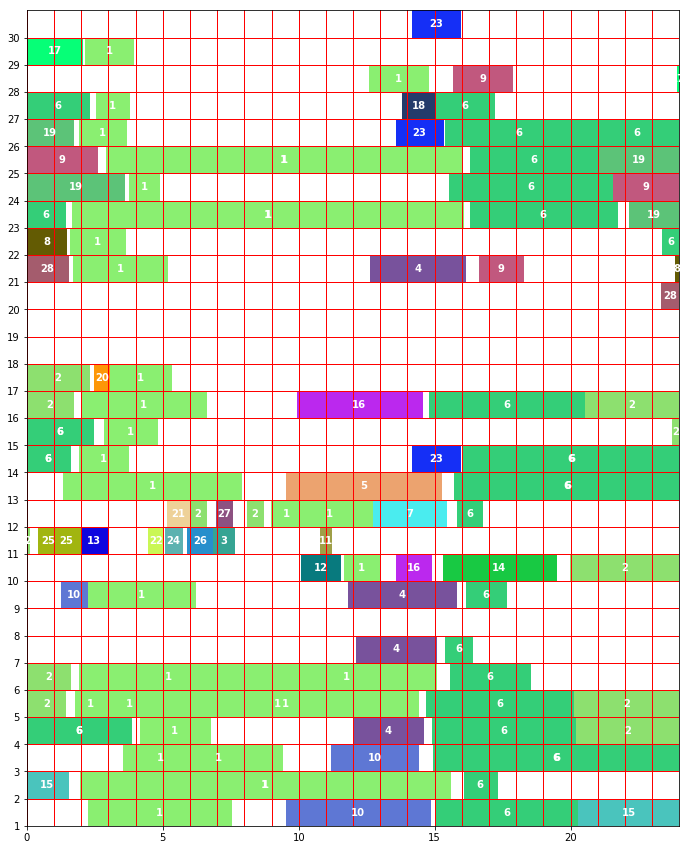

In [3]:
#visualize staypoints offline
#---------------------------------------------------------------------------------------------------
def directory_setup():
    #create directories for output
    usr_directory = dest_path + "/User " + user
    mnth_directory = dest_path + "/User " + user + "/" + month
    
    if not os.path.exists(usr_directory):
        os.makedirs(usr_directory)
    if not os.path.exists(mnth_directory):
        os.makedirs(mnth_directory)

    #remove if the file already exists
    try:
        os.remove(usr_offline_staypoints_1)
        os.remove(usr_offline_staypoints_2)
        os.remove(usr_offline_staypoints_3)
        os.remove(usr_offline_staypoints_at)
    except OSError:
        pass
    
#------------------------------------------------------------------------------------
#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters

#------------------------------------------------------------------------------------
def read_usr_file():
    global usr_trejec_df
    
    #Load file names for user
    filenames = glob.glob(file_source_raw)

    #Read the files
    list_of_dfs = [pd.read_csv(filename, skiprows=6, header = None) for filename in filenames]

    #put the data from list into one dataframe
    usr_trejec_df = pd.concat(list_of_dfs, ignore_index=True)
    usr_trejec_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
    usr_trejec_df["Timestamp"] = usr_trejec_df["Date"].map(str) + " " + usr_trejec_df["Time"]
    
    usr_trejec_df.Timestamp = pd.to_datetime(usr_trejec_df.Timestamp)
    
    usr_trejec_df.index = usr_trejec_df['Timestamp']
    usr_trejec_df = usr_trejec_df.resample('1T').mean()
    usr_trejec_df = usr_trejec_df.dropna()
    
     #add columns to user trajectory dataframe
    #1. add timestamp as column
    usr_trejec_df['Timestamp'] = pd.to_datetime(usr_trejec_df.index)
    #restore date and time column
    usr_trejec_df['Date'] = usr_trejec_df.Timestamp.dt.date
    usr_trejec_df['Time'] = usr_trejec_df.Timestamp.dt.time

    #sort values based on timestamp
    usr_trejec_df = usr_trejec_df.sort_values(['Timestamp'])
    #reset index
    usr_trejec_df = usr_trejec_df.reset_index(drop=True)
    
    #some test columns
    #distance between consicutive points to for further checks
    usr_trejec_df['Distance(Km)'] = 0
    for i in range(0, len(usr_trejec_df)-1):
        usr_trejec_df.loc[i+1, 'Distance(Km)'] = (meters(usr_trejec_df.loc[i, 'Latitude'],
                                                    usr_trejec_df.loc[i, 'Longitude'],
                                                   usr_trejec_df.loc[i+1, 'Latitude'],
                                                   usr_trejec_df.loc[i+1, 'Longitude'])) / 1000
    #time difference between two points
    usr_trejec_df['Time(Hr)'] = 0
    for i in range(0, len(usr_trejec_df)-1):
        usr_trejec_df.loc[i+1, 'Time(Hr)'] = (usr_trejec_df.loc[i+1, 'Timestamp'] -
                                              usr_trejec_df.loc[i, 'Timestamp']).seconds/3600
    #speed                                    
    usr_trejec_df['Speed(Km/Hr)'] = usr_trejec_df['Distance(Km)'] / usr_trejec_df['Time(Hr)']
    
    usr_trejec_df['Hour'] = usr_trejec_df.Timestamp.dt.hour
    
    #distance clusters
    usr_trejec_df['DistClus'] = 0
    usr_trejec_df['ClusDur'] = 0
    last_hr =  usr_trejec_df['Hour'][0]
    clusid = 0
    i = 0

    while i < len(usr_trejec_df)-1:
        clusid+=1
        
        #update the cluster duration
        if i != 0:
            usr_trejec_df.loc[i-1, 'ClusDur']= (usr_trejec_df.loc[i-1, 'Timestamp'] - 
                                            usr_trejec_df.loc[i-curr_clus_count, 'Timestamp']).seconds/60
        curr_clus_count = 1
        
        #add current cluster to mean values
        array_lat = usr_trejec_df.loc[i,'Latitude']
        array_lon = usr_trejec_df.loc[i,'Longitude']
        new_lat_mean = np.mean(array_lat)
        new_lon_mean = np.mean(array_lon)
        
        usr_trejec_df.loc[i, 'DistClus'] = clusid
        for j in range(i+1, len(usr_trejec_df)):
            #if the hour changes, stop j loop
            if usr_trejec_df.loc[j, 'Hour'] != last_hr:
                last_hr =  usr_trejec_df.loc[j, 'Hour']
                i=j
                break
            else:
                if meters(new_lat_mean, 
                           new_lon_mean, 
                           usr_trejec_df.loc[j,'Latitude'], 
                           usr_trejec_df.loc[j,'Longitude'])<= staypts_d_thrhld:
                        curr_clus_count+=1
                        
                        array_lat= np.append(array_lat, usr_trejec_df.loc[j,'Latitude'])
                        array_lon= np.append(array_lon, usr_trejec_df.loc[j,'Longitude'])
                        new_lat_mean = np.mean(array_lat)
                        new_lon_mean = np.mean(array_lon)
        
                        usr_trejec_df.loc[j, 'DistClus'] = usr_trejec_df.loc[i, 'DistClus']
                        
                else:
                    i=j
                    break
        i=j
        

    usr_trejec_df['Weekday'] = usr_trejec_df['Timestamp'].dt.weekday.map(str) + usr_trejec_df['Timestamp'].dt.weekday_name

    usr_trejec_df['StayPoint'] = -1 # 1 if it is a staypoint, else 0
    usr_trejec_df['StayptId'] = -1
    usr_trejec_df['StayMeanLat'] = -1.0
    usr_trejec_df['StayMeanLon'] = -1.0
    usr_trejec_df['State'] = -1     # 1 if it is a state, else 0
    usr_trejec_df['StateId'] = -1
    usr_trejec_df['StateMeanLat'] = -1.0
    usr_trejec_df['StateMeanLon'] = -1.0
    
    #remove columns not used/required
    usr_trejec_df = usr_trejec_df.drop(['0', 'Altitude', 'NumDays'], axis = 1)
    
    file_name = dest_path + "/User " + user + "/" + month + "/input_trj_data.csv"
    usr_trejec_df.to_csv(file_name, sep='\t', encoding='utf-8')
    
#-----------------------------------------------------------------------------------
def offline_staypoints():
    global off_staypts
    
    curr_cluster = usr_trejec_df.loc[0, 'DistClus']
    count_clus = 1
    lat_arr = []
    lon_arr = []
    row_dest = 0
    
    for i in range(1, len(usr_trejec_df)):
        
        if usr_trejec_df.loc[i, 'DistClus'] == curr_cluster:
            count_clus = count_clus + 1
        else:
            if usr_trejec_df.loc[i-1, 'ClusDur'] >= 20:
                
                lat_arr = []
                lon_arr = []
                end = usr_trejec_df.loc[i-1, 'Timestamp'] 
                start = usr_trejec_df.loc[i-count_clus, 'Timestamp']
                id_n = usr_trejec_df.loc[i-1, 'DistClus'] 
                for j in range(i-count_clus-1, i-1):
                    lat_arr = np.append(lat_arr, usr_trejec_df.loc[j, 'Latitude'])
                    lon_arr = np.append(lon_arr, usr_trejec_df.loc[j, 'Longitude'])
                
                lat_mean = np.mean(lat_arr)
                lon_mean = np.mean(lon_arr)
               
                off_staypts.loc[row_dest, 'id'] = id_n
                off_staypts['groupid'] = 0
                off_staypts.loc[row_dest, 'start'] = start
                off_staypts.loc[row_dest, 'end'] = end
                off_staypts.loc[row_dest, 'meanlat'] = lat_mean
                off_staypts.loc[row_dest, 'meanlon'] = lon_mean
                off_staypts.loc[row_dest, 'StartEndStayptFlag'] = 'N'
                row_dest = row_dest + 1
                
            curr_cluster = usr_trejec_df.loc[i, 'DistClus']
            count_clus = 1
                
        if int(time.mktime(usr_trejec_df.loc[i, 'Timestamp'].timetuple()) - 
               time.mktime(usr_trejec_df.loc[i-1, 'Timestamp'].timetuple()))/60 >= 30:
            if usr_trejec_df.loc[i-1, 'ClusDur'] < 20:
                off_staypts.loc[row_dest, 'id'] =  usr_trejec_df.loc[i-1, 'DistClus'] 
                off_staypts['groupid'] = 0
                off_staypts.loc[row_dest, 'start'] =  usr_trejec_df.loc[i-1, 'Timestamp'] 
                off_staypts.loc[row_dest, 'end'] =  usr_trejec_df.loc[i-1, 'Timestamp'] 
                off_staypts.loc[row_dest, 'meanlat'] =  usr_trejec_df.loc[i-1, 'Latitude'] 
                off_staypts.loc[row_dest, 'meanlon'] =  usr_trejec_df.loc[i-1, 'Longitude']
                off_staypts.loc[row_dest, 'StartEndStayptFlag'] = 'Y'
                row_dest = row_dest + 1

            off_staypts.loc[row_dest, 'id'] =  usr_trejec_df.loc[i, 'DistClus'] 
            off_staypts['groupid'] = 0
            off_staypts.loc[row_dest, 'start'] =  usr_trejec_df.loc[i, 'Timestamp'] 
            off_staypts.loc[row_dest, 'end'] =  usr_trejec_df.loc[i, 'Timestamp'] 
            off_staypts.loc[row_dest, 'meanlat'] =  usr_trejec_df.loc[i, 'Latitude'] 
            off_staypts.loc[row_dest, 'meanlon'] =  usr_trejec_df.loc[i, 'Longitude'] 
            off_staypts.loc[row_dest, 'StartEndStayptFlag'] = 'Y'
            row_dest = row_dest + 1
    
    #remove staypoints added from start end trajectories which are also part of staypoints within trajectories
    i = 0
    length_df = len(off_staypts)
    for i in range(0, len(off_staypts)-1):
        
        if off_staypts.loc[i, 'id'] == off_staypts.loc[i+1, 'id']:
            if off_staypts.loc[i, 'StartEndStayptFlag'] == 'Y':
                index_n = i
            else:
                index_n = i+1
    
            off_staypts.loc[index_n, 'StartEndStayptFlag'] = 'D'
    
    off_staypts = off_staypts[off_staypts.StartEndStayptFlag != 'D']        
    off_staypts = off_staypts.reset_index(drop=True)
    
    off_staypts.to_csv(usr_offline_staypoints_1, sep='\t', encoding='utf-8')
    
    #adjust start and end of staypoints
    for i in range(0, len(off_staypts)-1):
        end1_trj_time = off_staypts.loc[i, 'end']
        end1_trj_lat = off_staypts.loc[i, 'meanlat']
        end1_trj_lon = off_staypts.loc[i, 'meanlon']
        str2_trj_time = off_staypts.loc[i+1, 'start']
        str2_trj_lat = off_staypts.loc[i+1, 'meanlat']
        str2_trj_lon = off_staypts.loc[i+1, 'meanlon']
        
        dist_btw = meters(end1_trj_lat, end1_trj_lon, str2_trj_lat, str2_trj_lon)
        time_btw = (str2_trj_time - end1_trj_time).seconds / 60
        
        if time_btw != 0:
            avg_speed = dist_btw/time_btw
            
            #if the disctance between two points is less than 2*state_d_thrhld, that mean there is an overlap
            # in this case, we cannot consider state_d_thrhld as the staypoint region, as:
            #             before you leave state_d_thrhld of this staypoint the user already enters the next staypoint
            if (dist_btw >= 2*state_d_thrhld or dist_btw <= state_d_thrhld):
                delta_t = min(state_d_thrhld, dist_btw)/avg_speed
                
            else:
                delta_t = dist_btw/(2* avg_speed)
        
            end1_trj_time = end1_trj_time + timedelta(minutes=delta_t)
            str2_trj_time = str2_trj_time - timedelta(minutes=delta_t)
            
            if dist_btw<= 200:
                mean_lat = (off_staypts.loc[i, 'meanlat'] + off_staypts.loc[i+1, 'meanlat'])/2
                mean_lon = (off_staypts.loc[i, 'meanlon'] + off_staypts.loc[i+1, 'meanlon'])/2
                off_staypts.loc[i, 'meanlat'] =  mean_lat
                off_staypts.loc[i, 'meanlon'] = mean_lon
                off_staypts.loc[i+1, 'meanlat'] = mean_lat
                off_staypts.loc[i+1, 'meanlon'] = mean_lon
             
            off_staypts.loc[i, 'end'] = end1_trj_time
            off_staypts.loc[i+1, 'start'] = str2_trj_time
    
    #delete all staypoints with duration less than 20 minutes
    off_staypts.start = pd.to_datetime(off_staypts.start)
    off_staypts.end = pd.to_datetime(off_staypts.end)
    off_staypts['duration'] = 0.0
    for i in range(0, len(off_staypts)):
        duration = off_staypts.loc[i, 'end']-off_staypts.loc[i, 'start']
        seconds = duration.seconds
        minutes = seconds / 60
        off_staypts.loc[i, 'duration'] = minutes
        
    off_staypts = off_staypts[off_staypts.duration >= 20] 
    off_staypts = off_staypts.reset_index(drop=True)

    off_staypts.to_csv(usr_offline_staypoints_2, sep='\t', encoding='utf-8')
    
    #group staypoints
    off_staypts1 = off_staypts[['id', 'meanlat', 'meanlon']].copy()
    off_staypts1['groupid'] = 0
    count_start = 0
    id_num = 1
    while (count_start< len(off_staypts1)):
        off_staypts1['groupid'][count_start] = id_num
        i = count_start
        for j in range(i+1, len(off_staypts1)):
            
            chk_clulat = off_staypts1['meanlat'][i]
            chk_clulon = off_staypts1['meanlon'][i]
            curr_clulat = off_staypts1['meanlat'][j]
            curr_clulon = off_staypts1['meanlon'][j]
            
            if meters(chk_clulat, chk_clulon, curr_clulat, curr_clulon)<= state_d_thrhld:
                off_staypts1['groupid'][j] = id_num
                count_start = count_start + 1
        
        off_staypts1 = off_staypts1.sort_values(by = ['groupid'], ascending=False)
        off_staypts1 = off_staypts1.reset_index(drop=True)
        count_start = count_start + 1
        id_num = id_num + 1
            
    #create group id dict and update in  main dataframe
    grp_dict = pd.Series(off_staypts1.groupid.values,index=off_staypts1.id).to_dict()
    
    for i in range(0, len(off_staypts)):
        groupid = grp_dict.get(off_staypts.loc[i, 'id'])
        off_staypts.loc[i, 'groupid'] = groupid
        
    off_staypts.to_csv(usr_offline_staypoints_3, sep='\t', encoding='utf-8')
    visualize_off_staypoints()
    
def visualize_off_staypoints():
    
    #plot the offline staypoints
    #create a new graph where we will later add rectangles for each hour:cluster
    #create a color dictionary for each cluster for the plot
    
    
    dicts = {}
    clu_list = []
    clu_list = off_staypts['groupid'].unique()
    r = lambda: random.randint(0,255)
    for i in range(0, len(clu_list)):
        dicts[clu_list[i]] = ('#%02X%02X%02X' % (r(),r(),r()))
    
    fig2 = plt.figure(figsize=(15,15))
    ax1 = fig2.add_subplot(111, aspect='equal')
    
    #get all the dates for y axis
    date_list = off_staypts['start'].dt.date.unique()
    date_range = list(range(min(date_list).day, max(date_list).day+ 1))
    y = range(0, len(date_range))
    def_yticks = date_range
    plt.yticks(y, def_yticks)
    
    #drawing verical lines for each hour
    for i in range(0, 24):
        ax1.axvline(x= i, linewidth=1, color='r')
    #horizontal lines
    for i in range(min(date_list).day, max(date_list).day):
        ax1.axhline(y= i, linewidth=1, color='r')
        
    #set the x axis limit from 0-24 hours of a day, y axis with dates
    limsx = (0, 24)
    limsy = (0, len(date_range))

    date_counter = 0
    last_date = off_staypts['start'][0].date()
    
    for i in range(0, len(off_staypts)):
       
        if (last_date != off_staypts['start'][i].date()):
            add_days = (off_staypts['start'][i].date() - last_date).days
            date_counter = date_counter + add_days
            last_date = off_staypts['start'][i].date()
            
        #if the trajectory is going to next day
        if (off_staypts['start'][i].date() !=
           off_staypts['end'][i].date()):
            #day 1 rectangle
            a = (off_staypts['start'][i].hour + 
             off_staypts['start'][i].minute/60)
            b = 24
            width = b - a
            height = 1
            col_id = dicts.get(off_staypts['groupid'][i])
            ax1.add_patch(patches.Rectangle((a, date_counter), width, height, color=col_id, label=off_staypts['groupid'][i]))
            ax1.annotate(off_staypts['groupid'][i], (a + width/2, height/2 + date_counter), 
                     color='w', weight='bold', fontsize=10, ha='center', va='center')
            
            #day 2 rectangle
            a = 0
            b = (off_staypts['end'][i].hour + 
             off_staypts['end'][i].minute/60)
            width = b - a
            height = 1

            col_id = dicts.get(off_staypts['groupid'][i])
            ax1.add_patch(patches.Rectangle((a, date_counter+1), width, height, color=col_id, label=off_staypts['groupid'][i]))
            ax1.annotate(off_staypts['groupid'][i], (a + width/2, height/2 + date_counter+1), 
                     color='w', weight='bold', fontsize=10, ha='center', va='center')
            
        if (off_staypts['start'][i].date() ==
           off_staypts['end'][i].date()):    
            a = (off_staypts['start'][i].hour + 
                 off_staypts['start'][i].minute/60)
            b = (off_staypts['end'][i].hour +
                off_staypts['end'][i].minute/60)
            width = b - a
            height = 1
            
            col_id = dicts.get(off_staypts['groupid'][i])
            ax1.add_patch(patches.Rectangle((a, date_counter), width, height, color=col_id, label=off_staypts['groupid'][i]))
            ax1.annotate(off_staypts['groupid'][i], (a + width/2, height/2 + date_counter), 
                     color='w', weight='bold', fontsize=10, ha='center', va='center')

    
    plt.xlim(limsx)
    plt.ylim(limsy)
    destpng = dest_path + "/User " + user + "/" + month + "/offline.png"
    plt.savefig(destpng)
    plt.show()
    
    #off_staypts.to_csv(usr_offline_staypoints_at, sep='\t', encoding='utf-8')
#-------------------------------
def prepare_dfs():
    global cluster_hourly_df    
    
    #create off_staypts
    off_staypts['id'] = 0
    off_staypts['groupid'] = 0
    off_staypts['start'] = 0
    off_staypts['end'] = 0
    off_staypts['meanlat'] = 0
    off_staypts['meanlon'] = 0
    off_staypts['StartEndStayptFlag'] = 'N'

#--------------------------------MAIN--------------------------------------------------------------
def main():
    global usr_trejec_df
    
    #create directories
    directory_setup()
    
    #prepere dataframes
    prepare_dfs()
    
    #read test user trajectory file. In real scenerio, this will be the GPS read data
    read_usr_file()
    
    #find offline staypoints
    offline_staypoints()

#-----------------------------CHANGE HERE --------------------------------------------------------

state_d_thrhld = 200    #state distance threshold
staypts_d_thrhld = 200  #staypoint distance threshold
staypts_t_thrhld = 20   #staypoint time threshold
state_d_thrhld = 200    #state distance threshold

#Edit user name, and path locations for source and destination files
user = "020"
month = "201109"
file_src = "C:/Users/12sha/Documents/Geolife Trajectories 1.3/Data/"
dest_path = "C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.6 results"

file_source_raw = file_src + user + "/Trajectory/" + month + "*.plt"
#destination files
usr_offline_staypoints_1 = dest_path + "/User " + user + "/" + month + "/offline_staypoints_1.csv"
usr_offline_staypoints_2 = dest_path + "/User " + user + "/" + month + "/offline_staypoints_2.csv"
usr_offline_staypoints_3 = dest_path + "/User " + user +  "/" + month + "/offline_staypoints_3.csv"
usr_offline_staypoints_at = dest_path + "/User " + user +  "/" + month + "/staypoints(with added times).csv"
#------------------------------DATAFRAME DECLARATIONS---------------------------------------------


#global dataframes used

usr_trejec_df = pd.DataFrame() #user raw trajectory dataframe

off_staypts = pd.DataFrame() #offline staypoints
#---------------------------------------------------------------------------------------------------------
main()